In [1]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class LinearRegression:
    
    def __init__(self, X, y, max_iteration, epsilon, learning_rate, solution_type, reg, batch_size) -> None: #to globalise X, y and all so that it is accessible outside the class
        self.X = X
        self.y = y
        self.max_iteration = max_iteration
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.solution_type = solution_type
        self.reg = reg
        self.L = 1 #(setting default value to 1 for with regression)
        self.batch_size = batch_size
        
    def data_split(self):
        self.trainX, self.testX, self.trainy, self.testy = train_test_split(self.X,
                                                                            self.y,
                                                                            test_size=0.3, shuffle=True)
        
    def add_X0(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])
    
    def train_scaling(self, X):
        mean  = np.mean(X, axis=0)
        std  = np.std(X, axis=0)
        X = (X - mean) / std
        X = self.add_X0(X)
        return X, mean, std
    
    def test_scaling(self, X, mean, std):
        X = (X - mean) / std
        X = self.add_X0(X)
        return X
    
    def rank(self, X):
        v, s, u = np.linalg.svd(X)
        #rank = np.sum(s>0.00001)
        rank = np.linalg.matrix_rank(X)
        return rank
    
    def full_rank(self, X):
        rank = self.rank(X)
        if rank == min(X.shape):
            self.fullRank = True
            print("Its full rank")
        else:
            self.fullRank = False
            print("Its not full rank")
            
    def low_rank(self, X):
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
            print("Its low rank")
        else:
            self.lowRank = False
            print("Its not low rank")
            
    def closed_form_solution(self, X, y):
        if (self.reg is True):
            #self.w = np.linalg.inv(X.T.dot(X)+ self.L*np.eye(X.shape[1])).dot(X.T).dot(y)
            self.w = np.linalg.inv(X.T.dot(X)+ self.L*np.eye((X.T.dot(X)).shape[0])).dot(X.T).dot(y)
        else:
            self.w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    def predict(self, X):
        return X.dot(self.w)
    
    def sse(self, X, y):
        y_hat = self.predict(X)
        return((y_hat - y) ** 2).sum()
    
    def rmse(self, X, y):
        return np.sqrt((self.sse(X, y)) / X.shape[0])
    
    def cost_function(self, X, y):
        loss = self.sse(X,y)
        return loss / 2
    
    def cost_derivative(self, X, y):
        y_hat = self.predict(X)
#         return X.T.dot(y_hat-y)
        if (self.reg is True):
            res = X.T.dot(y_hat-y)+(self.L*self.w)
        else:
            res = X.T.dot(y_hat-y)
        return res
        
    
    def gradient_descent(self, X, y):
        errors = []
        prev_error = float("inf")
        for t in tqdm(range(self.max_iteration), colour = 'blue'):
            #self.w -= self.learning_rate * self.cost_derivative(X, y) + (self.L*self.w)
            self.w -= self.learning_rate * self.cost_derivative(X, y)
            loss = self.sse(X, y)
            errors.append(loss)
            if abs(loss - prev_error) < self.epsilon:
                print("Model stopped learning")
                break
            prev_error = loss
        self.plot_rmse(errors)
    
    def stochastic_gd(self, X, y):
        #sample_size= round(X.shape[0]/2)   # To set a batch size equal to half of the total size
        sample_size = self.batch_size
        X = X[:sample_size, :]
        y = y[:sample_size]
        errors = []
        prev_error = float("inf")
        for t in tqdm(range(self.max_iteration), colour = 'blue'):
            self.w -= self.learning_rate * self.cost_derivative(X, y)
            loss = self.sse(X, y)
            errors.append(loss)
            if abs(loss - prev_error) < self.epsilon:
                print("Model stopped learning")
                break
            prev_error = loss
        self.plot_rmse(errors)
        
    def fit(self):
        self.data_split()
        self.trainX, mean, std  = self.train_scaling(self.trainX)
        self.testX = self.test_scaling(self.testX, mean, std)
        self.full_rank(self.trainX)
        self.low_rank(self.trainX)
        if self.fullRank and not self.lowRank and self.trainX.shape[1] < 1000 and self.solution_type=='closed':
            self.closed_form_solution(self.trainX, self.trainy)
        else:
            self.w = np.zeros(self.trainX.shape[1])
            if self.solution_type=='gd':
                self.gradient_descent(self.trainX, self.trainy)
            else:
                self.stochastic_gd(self.trainX, self.trainy)
        print("Coefficients: ",self.w)
        print('SSE:', self.sse(self.testX, self.testy))
        print('RMSE:', self.rmse(self.testX, self.testy))

    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        #ax.set(xlabel='iterations', ylabel=self.error,
         #      title='{} trend'.format(self.error))
        plt.xlabel('iterations')
        plt.ylabel('Cost Function')
        ax.grid()

        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()    

# Housing Dataset

In [3]:
df=pd.read_csv('housing.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
X= df.values[:,:-1]
y= df.values[:,-1]

In [5]:
# Using Closed form Solution and with Regularization
lr=LinearRegression(X,y, learning_rate=0.0004, epsilon=0.005, max_iteration=50000, solution_type='closed', reg=True, batch_size=200)
lr.fit()

Its full rank
Its not low rank
Coefficients:  [22.53380282 -0.81662528  1.12111621 -0.13125222  0.72269001 -2.35812065
  2.40280311 -0.29125521 -3.42599014  2.18664201 -1.63263687 -2.20174469
  0.98848982 -3.66187065]
SSE: 3671.3151954988352
RMSE: 4.9146097957082295


In [6]:
# Using Closed form Solution and without Regularization
lr=LinearRegression(X,y, learning_rate=0.0004, epsilon=0.005, max_iteration=50000, solution_type='closed', reg=False, batch_size=200)
lr.fit()

Its full rank
Its not low rank
Coefficients:  [21.9680791  -1.23556076  1.01276111 -0.0477291   0.39348825 -2.20727994
  2.25778584  0.28196583 -2.99173086  2.73984726 -2.28282516 -2.12044273
  0.58138349 -3.72372977]
SSE: 4034.5755709008354
RMSE: 5.152015172228622


Its full rank
Its not low rank


  1%|▎                                   | 481/50000 [00:00<00:03, 15939.36it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


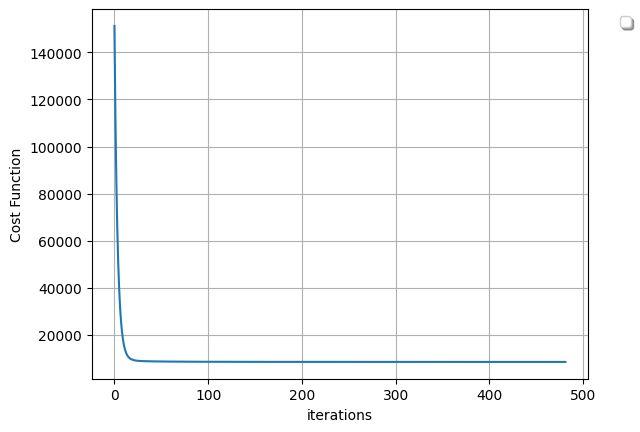

Coefficients:  [22.6543662  -0.6570514   1.08490564 -0.11470622  0.60361904 -2.04593043
  2.60759118  0.21492697 -3.12579381  2.59609306 -1.93270072 -1.96909029
  0.76214238 -4.07086759]
SSE: 2809.929025900662
RMSE: 4.299578487526317


In [7]:
# Using gradient descent solution and with regularization
lr=LinearRegression(X,y, learning_rate=0.0004, epsilon=0.005, max_iteration=50000, solution_type='gd', reg=True, batch_size=200)
lr.fit()

Its full rank
Its not low rank


  1%|▎                                   | 386/50000 [00:00<00:01, 29227.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


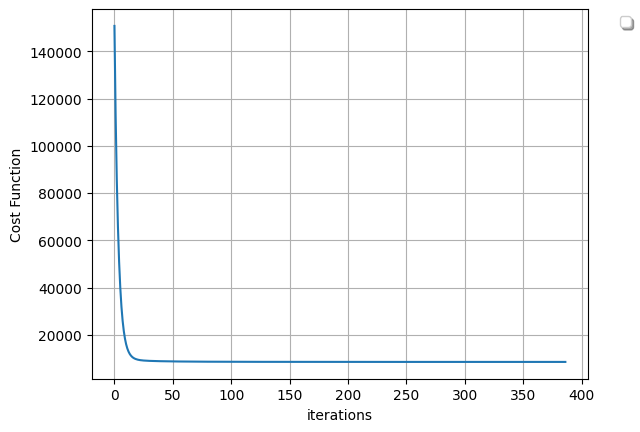

Coefficients:  [22.63841808 -1.06884558  1.3781077   0.32894972  0.70920037 -2.71141886
  2.42035008  0.47423119 -3.21140523  2.94849507 -1.91118371 -2.1606569
  0.85516927 -4.08873435]
SSE: 2715.96940302
RMSE: 4.227081706888398


In [8]:
# Using gradient descent solution and without regularization
lr=LinearRegression(X,y, learning_rate=0.0004, epsilon=0.005, max_iteration=50000, solution_type='gd', reg=False, batch_size=200)
lr.fit()

Its full rank
Its not low rank


  1%|▌                                   | 736/50000 [00:00<00:01, 38132.86it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


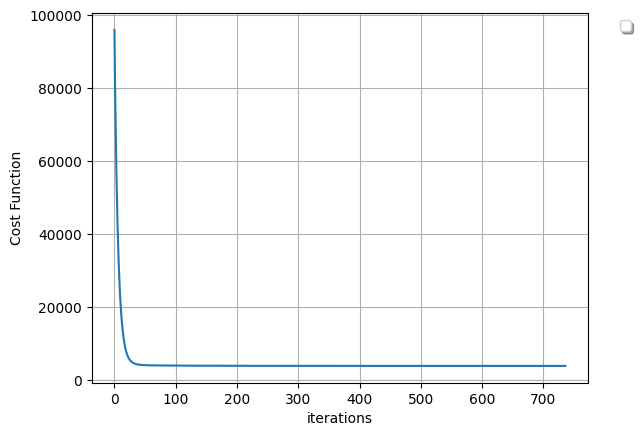

Coefficients:  [22.03093607 -1.0637394   1.31978889 -0.11225223  0.29018167 -1.03294744
  2.63175584 -0.37068986 -3.63116617  2.48989317 -2.74993076 -1.30357755
  0.67701998 -4.30068422]
SSE: 2777.3990748125625
RMSE: 4.274618384638934


In [9]:
# Using stochastic gradient descent solution and with regularization
lr=LinearRegression(X,y, learning_rate=0.0004, epsilon=0.005, max_iteration=50000, solution_type='sgd', reg=True, batch_size=200)
lr.fit()

Its full rank
Its not low rank


  1%|▍                                   | 532/50000 [00:00<00:01, 48408.06it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


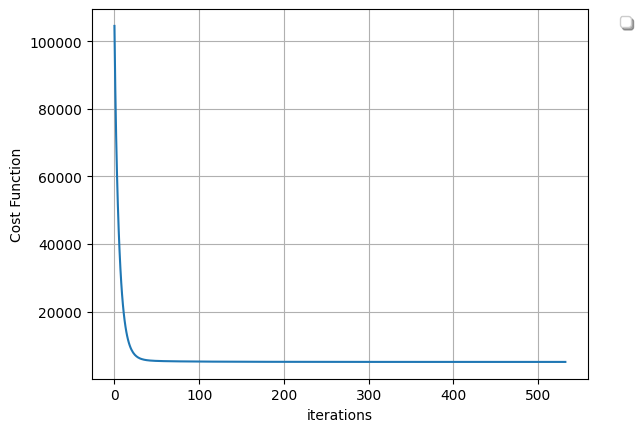

Coefficients:  [22.79131544 -1.43690276  0.71564404  0.92274941  0.76316768 -2.61838646
  3.48815138 -0.20856897 -2.68183763  3.22986097 -1.8733967  -2.06963946
  0.73266392 -3.38973686]
SSE: 2965.860238660512
RMSE: 4.417265943119139


In [10]:
# Using stochastic gradient descent solution and without regularization
lr=LinearRegression(X,y, learning_rate=0.0004, epsilon=0.005, max_iteration=50000, solution_type='sgd', reg=False, batch_size=200)
lr.fit()

# Yacht Dataset

In [11]:
df2=pd.read_csv('yachtData.csv', header=None)
df2.head()

,0,1,2,3,4,5,6
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [12]:
X= df2.values[:,:-1]
y= df2.values[:,-1]

In [13]:
# Using Closed form Solution and with Regularization
lr=LinearRegression(X,y, learning_rate=0.001, epsilon=0.001, max_iteration=50000, solution_type='closed', reg=True, batch_size=200)
lr.fit()

Its full rank
Its not low rank
Coefficients:  [10.06041667 -0.16326556  0.4711839   2.45457759 -1.95926541 -2.69797659
 11.84772611]
SSE: 9080.263120683001
RMSE: 9.881155694391545


In [14]:
# Using Closed form Solution and without Regularization
lr=LinearRegression(X,y, learning_rate=0.001, epsilon=0.001, max_iteration=50000, solution_type='closed', reg=False, batch_size=200)
lr.fit()

Its full rank
Its not low rank
Coefficients:  [10.23227907  0.66912795 -0.0154646   0.542332    0.32568348 -0.56378313
 11.85594143]
SSE: 9571.097522104306
RMSE: 10.144704387975095


Its full rank
Its not low rank


  3%|▉                                  | 1335/50000 [00:00<00:01, 39449.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


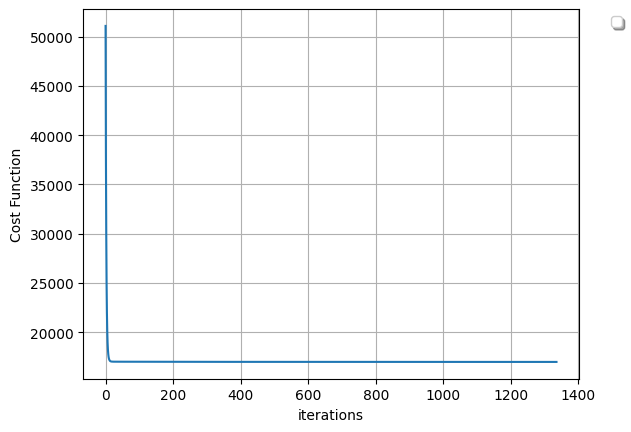

Coefficients:  [10.40152778  0.32923033  0.03333452  1.16003248 -1.62282767 -1.59616921
 12.11257459]
SSE: 7307.472661911681
RMSE: 8.864252639634397


In [15]:
# Using gradient descent solution and with regularization
lr=LinearRegression(X,y, learning_rate=0.001, epsilon=0.001, max_iteration=50000, solution_type='gd', reg=True, batch_size=200)
lr.fit()

Its full rank
Its not low rank


  3%|▉                                  | 1261/50000 [00:00<00:01, 43277.04it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


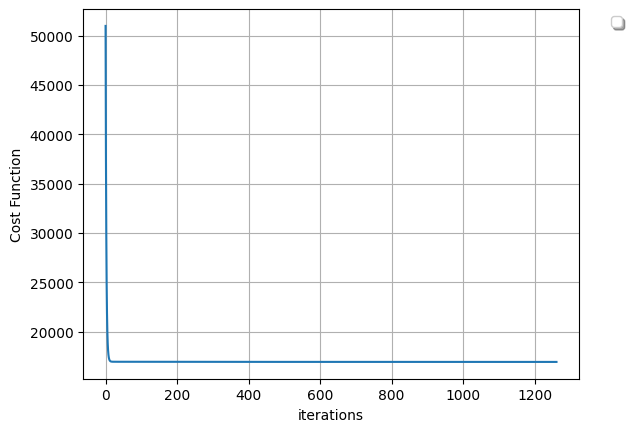

Coefficients:  [10.38334884  0.25494042  0.199813    1.61993028 -1.46998737 -1.99675558
 12.19957893]
SSE: 7302.859134829845
RMSE: 8.86145400265561


In [16]:
# Using gradient descent solution and without regularization
lr=LinearRegression(X,y, learning_rate=0.001, epsilon=0.001, max_iteration=50000, solution_type='gd', reg=False, batch_size=200)
lr.fit()

Its full rank
Its not low rank


  1%|▌                                   | 716/50000 [00:00<00:01, 35634.36it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


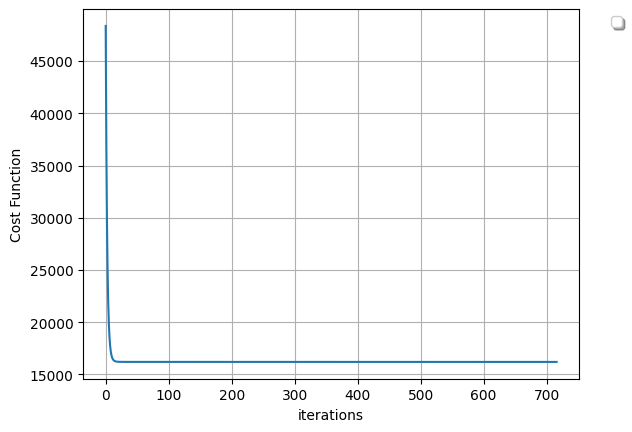

Coefficients:  [10.05262435  0.34271247 -1.20013455 -0.41932173  0.6789002  -0.06018066
 12.20191242]
SSE: 7426.794819464672
RMSE: 8.936330836056154


In [17]:
# Using stochastic gradient descent solution and with regularization
lr=LinearRegression(X,y, learning_rate=0.001, epsilon=0.001, max_iteration=50000, solution_type='sgd', reg=True, batch_size=200 )
lr.fit()

Its full rank
Its not low rank


  0%|                                     | 41/50000 [00:00<00:04, 11370.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


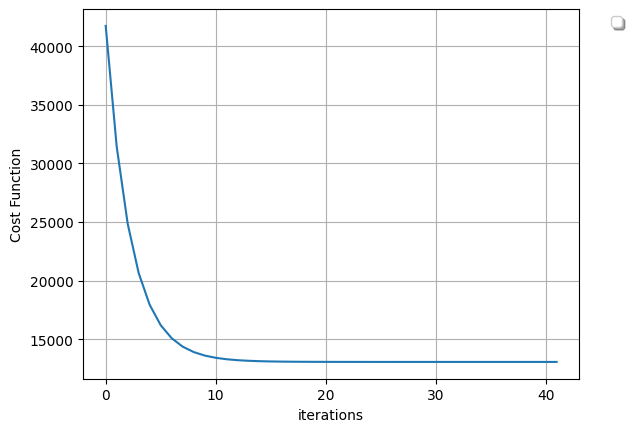

Coefficients:  [ 9.43124185  0.42548641  0.16817075 -0.23245728 -0.46074194  0.04874486
 11.64209877]
SSE: 9194.854646566717
RMSE: 9.943309549732053


In [18]:
# Using stochastic gradient descent solution and without regularization
lr=LinearRegression(X,y, learning_rate=0.001, epsilon=0.001, max_iteration=50000, solution_type='sgd', reg=False, batch_size=200 )
lr.fit()

# Concrete Data

In [19]:
df3=pd.read_csv('concreteData.csv', header=None)
df3.head()

,0,1,2,3,4,5,6,7,8
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [20]:
X= df3.values[:,:-1]
y= df3.values[:,-1]

In [21]:
# Using Closed form Solution and with Regularization
lr=LinearRegression(X,y, learning_rate=0.0007, epsilon=0.0001, max_iteration=50000, solution_type='closed', reg=True, batch_size=200)
lr.fit()

Its full rank
Its not low rank
Coefficients:  [35.49117729 11.35925368  8.21329896  4.4811485  -4.13760395  1.67597642
  0.61911259  0.82865344  7.04195723]
SSE: 35256.65563682311
RMSE: 10.68172313724042


In [22]:
# Using Closed form Solution and without Regularization
lr=LinearRegression(X,y, learning_rate=0.0007, epsilon=0.0001, max_iteration=50000, solution_type='closed', reg=False, batch_size=200)
lr.fit()

Its full rank
Its not low rank
Coefficients:  [36.99833564 12.83725858  9.29988595  5.81134255 -2.8686243   1.5494555
  1.63014974  1.88316424  7.25352036]
SSE: 30346.367643004218
RMSE: 9.910010571350846


Its full rank
Its not low rank


  1%|▍                                   | 652/50000 [00:00<00:02, 16659.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


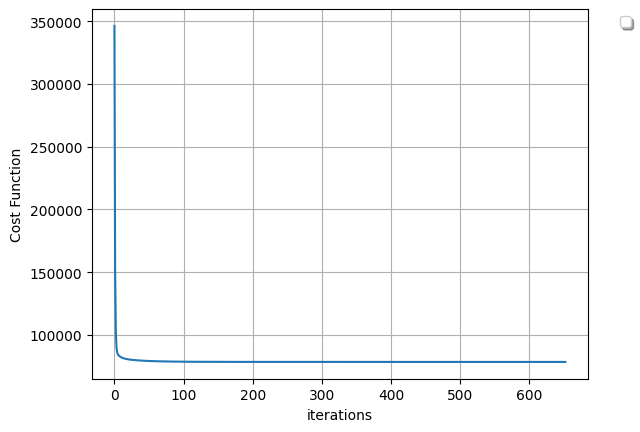

Coefficients:  [36.45231302 12.86387915  9.31888973  5.93399725 -3.32756041  1.43240875
  1.54197195  1.70093304  7.18565592]
SSE: 32109.5255433677
RMSE: 10.193837459309474


In [23]:
# Using gradient descent solution and with regularization
lr=LinearRegression(X,y, learning_rate=0.0007, epsilon=0.0001, max_iteration=50000, solution_type='gd', reg=True, batch_size=200)
lr.fit()

Its full rank
Its not low rank


  1%|▎                                   | 420/50000 [00:00<00:02, 24150.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


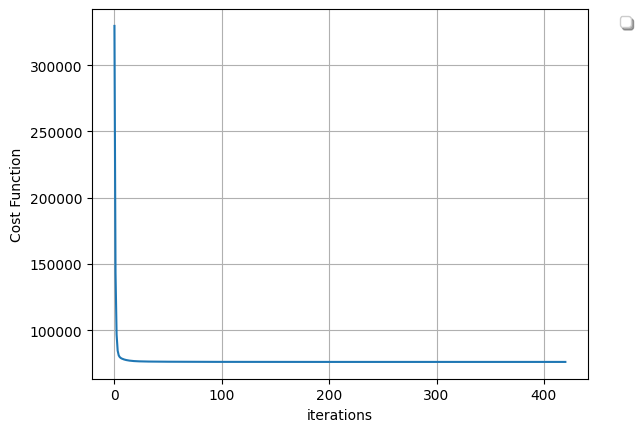

Coefficients:  [35.60585298  9.92992058  6.30619132  3.80457712 -5.75365623  0.87235224
 -0.78142974 -1.23049321  7.15774148]
SSE: 35689.10183892002
RMSE: 10.747032681294666


In [24]:
# Using gradient descent solution and without regularization
lr=LinearRegression(X,y, learning_rate=0.0007, epsilon=0.0001, max_iteration=50000, solution_type='gd', reg=False, batch_size=200)
lr.fit()

Its full rank
Its not low rank


  4%|█▍                                 | 1997/50000 [00:00<00:01, 47447.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


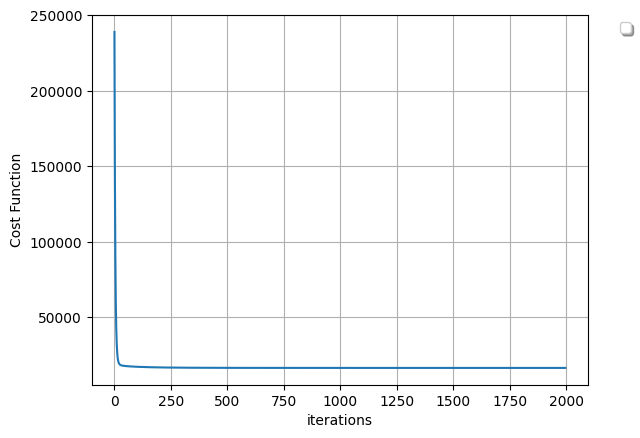

Coefficients:  [37.04110389 13.82256883 10.04516271  6.5195476  -2.75709844  2.39134615
  1.73207613  2.51941777  7.88283238]
SSE: 35774.28510494739
RMSE: 10.759850624098096


In [25]:
# Using stochastic gradient descent solution and with regularization
lr=LinearRegression(X,y, learning_rate=0.0007, epsilon=0.0001, max_iteration=50000, solution_type='sgd', reg=True, batch_size=200)
lr.fit()

Its full rank
Its not low rank


  3%|▉                                  | 1275/50000 [00:00<00:00, 51654.99it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


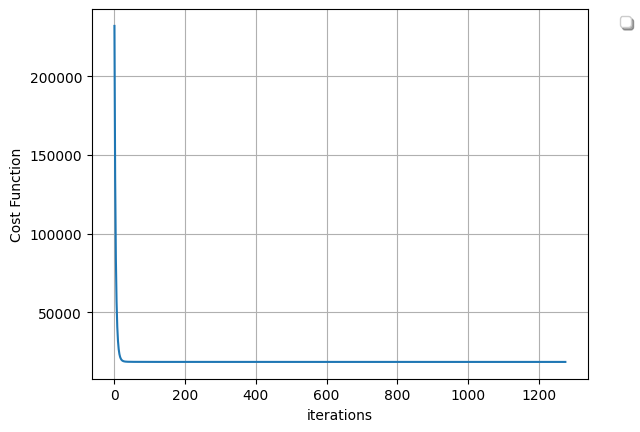

Coefficients:  [36.24738117  7.99215144  5.12349787  1.25607789 -5.65349938  3.39573983
 -1.12429065 -2.64968362  7.40070937]
SSE: 36917.825324320256
RMSE: 10.930469471247694


In [26]:
# Using stochastic gradient descent solution and without regularization
lr=LinearRegression(X,y, learning_rate=0.0007, epsilon=0.0001, max_iteration=50000, solution_type='sgd', reg=False, batch_size=200)
lr.fit()

# Observation:
We mostly see an **improved RMSE Score** with **Regularization**<br>
The **learning rate and regularization parameters** are **critical hyperparameters** in training machine learning models.<br><br>
**Learning rate** determines the size of the steps taken during optimization to update the model parameters whereas **Regularization Parameters** are used to prevent overfitting and improve generalization of the model.<br><br>
A high learning rate can lead to overshooting, preventing effective convergence. On the other hand, a low learning rate may result in sluggish convergence or the model becoming trapped in local minima.<br><br>
A high regularization parameter increases the penalty, leading to simpler models with lower variance but potentially higher bias, resulting in underfitting. Conversely, a low regularization parameter fosters more complex models with lower bias but higher variance, making them prone to overfitting.